<a href="https://colab.research.google.com/github/zuti666/generative-models/blob/master/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**GAN**



##**Generator**

### Generator 的目标使得 生成结果$P_G$和$P_{data}$越近越好

![image-20231004111331954](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004111332.png)

问题： 我们并不知道$P_G$和$P_{data}$这两个东西具体是什么

### **缺点**

问题就是，不能单纯只让我们的生成结果和目标结果一致，其实组成部分componet之间的关系也是重要的，但是在生成过程中，并不会关注到这种结构关系

![image-20211115105334861](https://zuti.oss-cn-qingdao.aliyuncs.com/img/image-20211115105334861.png)

## Discrimator
### Discriminator  用来度量$P_G$和$P_{data}$
Discrimator 就是一个函数，输入一个图片，输出一个评分

![image-20211115110025228](https://zuti.oss-cn-qingdao.aliyuncs.com/img/image-20211115110025228.png)


![image-20211115110217335](https://zuti.oss-cn-qingdao.aliyuncs.com/img/image-20211115110217335.png)

discriminator 做的是评价，在生成的时候是从底向上的，我们只关注到每个Component组成部分，而不容易注意到各部分之间的联系。但是在评价的时候我们是根据生成的样本与目标进行比较的，就能够关注到这种联系，也就是我们是从顶向下，站在整体的角度来看待的。

![image-20231004111556072](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004111556.png)

![image-20231004111850271](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004111850.png)

![image-20231004112123642](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004112123.png)

**主要思想**
![image-20211115192330884](https://zuti.oss-cn-qingdao.aliyuncs.com/img/image-20211115192330884.png)



##**算法流程**

![image-20231004115730293](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004115730.png)
-----------------

![image-20211115092201339](https://zuti.oss-cn-qingdao.aliyuncs.com/img/image-20211115092201339.png)
![image-20211115092500133](https://zuti.oss-cn-qingdao.aliyuncs.com/img/image-20211115092500133.png)

**公式**

## 数学证明  目标函数 等价于 最大分类的divergence

![image-20231004112514062](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004112514.png)

 ![image-20231004112843188](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004112843.png)

## 把目标结果带入原问题得到的结果就是 JS Divergence

![image-20231004113131805](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004113131.png)

![image-20231004113239643](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004113239.png)

##实际代码使用的损失函数

![image-20231004120014617](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004120014.png)

#代码

第一步 导入相关的库

In [ ]:
# 导入所需的库
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from torchvision import datasets, transforms

设置一些超参数

In [ ]:
# 设置一些超参数
mb_size = 64  # 每一批次的大小
Z_dim = 100  # 输入的随机向量维度z
X_dim = 784  # MNIST图像的大小为28x28，所以展平后的维度为784
y_dim = 10   # MNIST数据集中有10个类别
h_dim = 128
file_name = 0 #生成图片的名称
lr = 1e-3  #学习率

第二步 准备相关数据集，这里我们使用MINIST手写数字集合

In [ ]:
# 定义MNIST数据集的变换
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# 下载并加载MNIST数据集
mnist = datasets.MNIST('../../MNIST_data', train=True, transform=transform, download=True)
data_loader = torch.utils.data.DataLoader(mnist, batch_size=mb_size, shuffle=True, drop_last=True)

创建 生成器 和判别器，注意这里生成器的输入为z ,判别器的输入也是z

In [ ]:
# Generator model
class Generator(torch.nn.Module):
    def __init__(self):
        # 定义生成器的权重与偏置项。
        # 输入层为100个神经元且接受随机噪声，输出层为784个神经元，并输出手写字体图片。
        # 生成网络根据原论文为三层全连接网络
        super(Generator, self).__init__()
        self.fc1 = torch.nn.Linear(Z_dim, h_dim)
        self.fc2 = torch.nn.Linear(h_dim, X_dim)


    def forward(self, z):
        h = F.relu(self.fc1(z))
        X = torch.sigmoid(self.fc2(h))
        return X

# Discriminator model
class Discriminator(torch.nn.Module):
    def __init__(self):
        # 定义判别器的权重矩阵和偏置项向量，由此可知判别网络为三层全连接网络
        super(Discriminator, self).__init__()
        self.fc1 = torch.nn.Linear(X_dim, h_dim)
        self.fc2 = torch.nn.Linear(h_dim, 1)

    # 定义判别器的前向传播函数D(X),其中X是输入的手写数字图片，
    # 经过一系列全连接层和激活函数， 输出一个值，表示输入图片的真实性。
    def forward(self, X):
        h = F.relu(self.fc1(X))
        y = torch.sigmoid(self.fc2(h))
        return y

G = Generator()
D = Discriminator()

# Optimizers
G_solver = optim.Adam(G.parameters(), lr=1e-3)
D_solver = optim.Adam(D.parameters(), lr=1e-3)


def reset_grad():
    G.zero_grad()
    D.zero_grad()

设置真实数据和生成数据的标签

In [ ]:
ones_label = Variable(torch.ones(mb_size, 1))
zeros_label = Variable(torch.zeros(mb_size, 1))

训练过程

Iter-0; D_loss: 5.802408850286156e-05; G_loss: 9.759014129638672


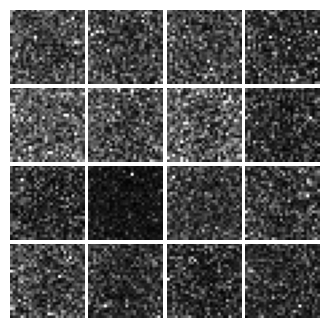

In [ ]:
# Training loop
for it in range(100000):
    for X, _ in data_loader:
        X = X.view(-1, X_dim)
        X = Variable(X)

        # Discriminator forward-loss-backward-update
        z = Variable(torch.randn(mb_size, Z_dim))
        G_sample = G(z)
        D_real = D(X)
        D_fake = D(G_sample)

        """计算判别器的损失，包括真实图片的损失和生成图片的损失，并更新判别器的参数。"""
        D_loss_real = F.binary_cross_entropy(D_real, ones_label)  # 真实图片的损失
        D_loss_fake = F.binary_cross_entropy(D_fake, zeros_label) # 生成图片的损失
        D_loss = D_loss_real + D_loss_fake

        # 更新判别器的参数
        D_loss.backward()
        D_solver.step()

        # Housekeeping - reset gradient
        reset_grad()

        # Generator forward-loss-backward-update
        """重新生成一批噪声数据z，用生成器生成图片，并计算生成器的损失，然后更新生成器的参数。"""
        z = Variable(torch.randn(mb_size, Z_dim))
        G_sample = G(z)
        D_fake = D(G_sample)

        G_loss = F.binary_cross_entropy(D_fake, ones_label)

        G_loss.backward()
        G_solver.step()

        # Housekeeping - reset gradient
        reset_grad()

    # Print and plot every now and then
    if it % 1000 == 0:
        # 在每1000次迭代后，打印当前的判别器损失和生成器损失。
        print('Iter-{}; D_loss: {}; G_loss: {}'.format(it, D_loss.data.numpy(), G_loss.data.numpy()))

        """可视化生成器生成的一批样本图片，将其保存在输出文件夹中。"""
        samples = G(z).data.numpy()[:16]

        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

        if not os.path.exists('out/'):
            os.makedirs('out/')

        plt.savefig('out/{}.png'.format(str(file_name).zfill(3)), bbox_inches='tight')
        plt.show()
        file_name += 1
        plt.close(fig)